# Title: Advanced Geospatial Regression Analysis with Multiscale Geographically Weighted Regression (MGWR)
# Author: Gurgen Hovakimyan
# Submission Date: 30/June/2024

## Introduction

Geospatial regression analysis considers spatial dependencies and relationships among geographic data points. This project demonstrates advanced geospatial regression using OLS, GWR, and MGWR on the "naturalearth_lowres" dataset. We aim to predict GDP per capita based on population density and other relevant variables while considering spatial dependencies and employing advanced spatial econometric techniques.

## Libraries

In [30]:
import numpy as np

import geopandas as gpd
import pandas as pd

import pysal.lib
from esda.moran import Moran, Moran_Local
from esda.geary import Geary

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import MGWR

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [8]:
# Importing the data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [9]:
world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    float64 
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    int64   
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


In [10]:
world.describe()

,pop_est,gdp_md_est
count,1.770000e+02,1.770000e+02
mean,4.324346e+07,4.934739e+05
std,1.513543e+08,2.019326e+06
min,1.400000e+02,1.600000e+01
25%,3.301000e+06,1.346900e+04
50%,1.019232e+07,5.040000e+04
75%,3.182530e+07,2.619210e+05
max,1.397715e+09,2.143323e+07


## Preprocessing

In [11]:
# Calculate the area of each country
world['area'] = world.geometry.to_crs(epsg=3395).area / 10**6  # Convert to square kilometers

# Calculate population density (people per square kilometer)
world['pop_density'] = world['pop_est'] / world['area']

# Calculate GDP per capita
world['gdp_per_capita'] = world['gdp_md_est'] * 1e6 / world['pop_est']

# Drop rows with missing values in relevant columns
world = world.dropna(subset=['pop_density', 'gdp_per_capita'])

# Display the first few rows with the new columns
print(world[['name', 'pop_density', 'gdp_per_capita']].head())


                       name  pop_density  gdp_per_capita
0                      Fiji    42.071341     6175.607026
1                  Tanzania    61.318547     1089.156033
2                 W. Sahara     5.180291     1503.515109
3                    Canada     0.721495    46194.708478
4  United States of America    15.057973    65297.517508


## Visualisation

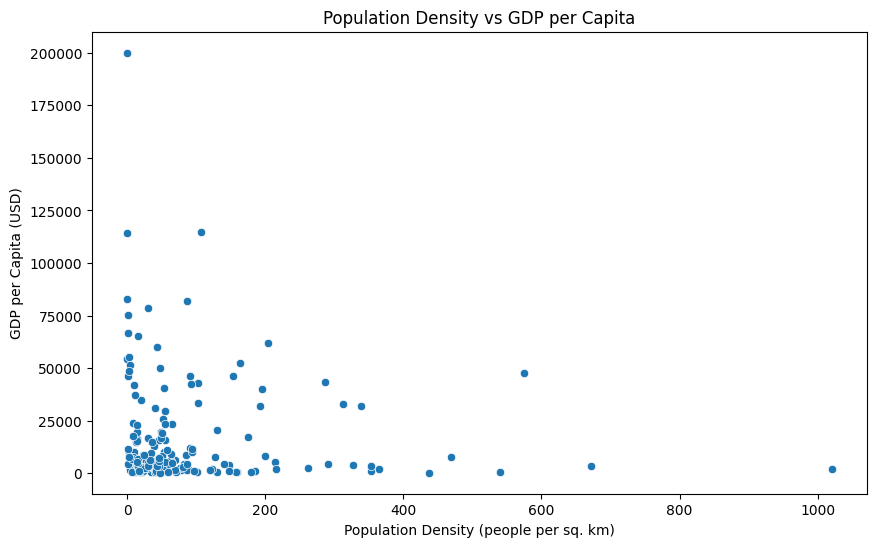

In [13]:
# Scatter plot of population density vs GDP per capita
plt.figure(figsize=(10, 6))
sns.scatterplot(data=world, x='pop_density', y='gdp_per_capita')
plt.xlabel('Population Density (people per sq. km)')
plt.ylabel('GDP per Capita (USD)')
plt.title('Population Density vs GDP per Capita')
plt.show()

<Figure size 1000x600 with 0 Axes>

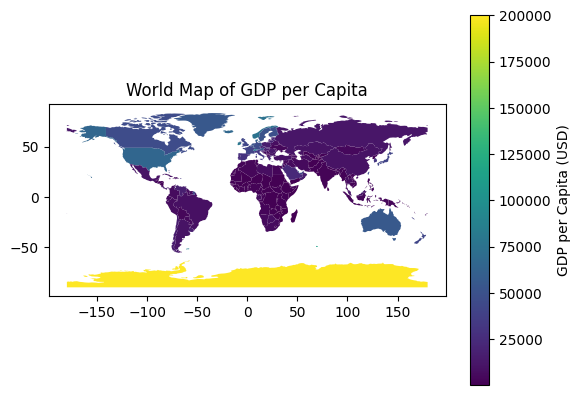

In [17]:
# Plot GDP per capita on the map
plt.figure(figsize=(10, 6))
world.plot(column='gdp_per_capita', legend=True, cmap='viridis', legend_kwds={'label': "GDP per Capita (USD)"})
plt.title('World Map of GDP per Capita')
plt.show()

<Figure size 1000x600 with 0 Axes>

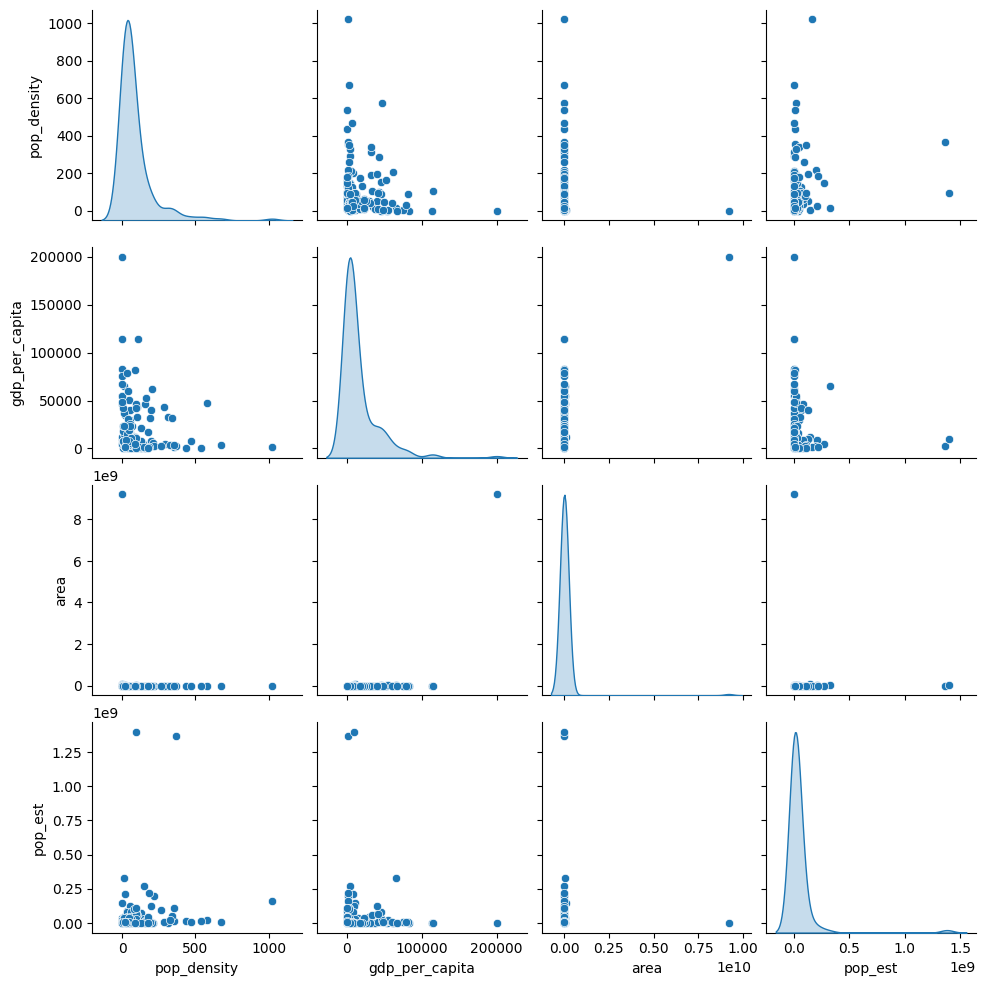

In [18]:
# Pair plot to explore relationships between variables
plt.figure(figsize=(10, 6))
sns.pairplot(world[['pop_density', 'gdp_per_capita', 'area', 'pop_est']], diag_kind='kde')
plt.show()

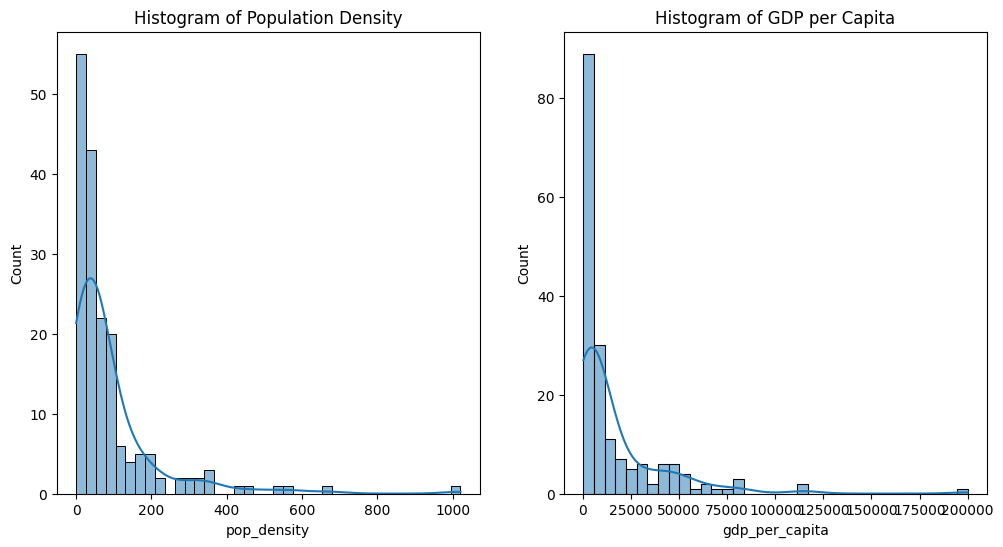

In [19]:
# Histograms of key variables
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(world['pop_density'], kde=True)
plt.title('Histogram of Population Density')
plt.subplot(1, 2, 2)
sns.histplot(world['gdp_per_capita'], kde=True)
plt.title('Histogram of GDP per Capita')
plt.show()

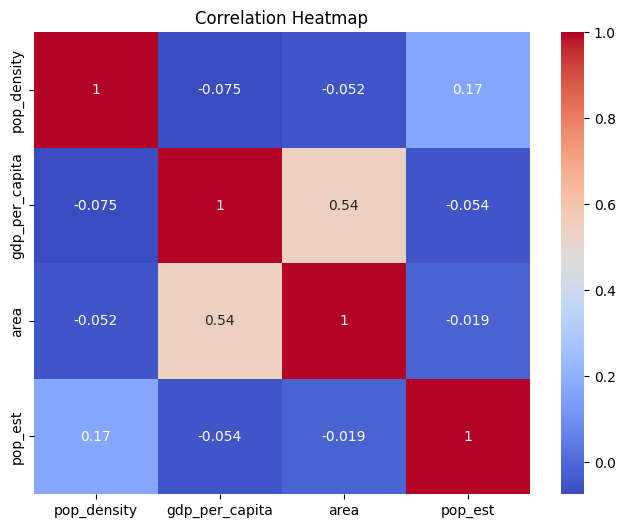

In [20]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(world[['pop_density', 'gdp_per_capita', 'area', 'pop_est']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Hypothesis Testing

In [22]:
# Create a spatial weights matrix
weights = pysal.lib.weights.Queen.from_dataframe(world)

# Calculate Moran's I for GDP per capita
moran = Moran(world['gdp_per_capita'], weights)
geary = Geary(world['gdp_per_capita'], weights)

# Display Moran's I and Geary's C values and p-values
print(f"Moran's I: {moran.I}, P-value: {moran.p_sim}")
print(f"Geary's C: {geary.C}, P-value: {geary.p_sim}")


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 78, ' is an island (no neighbors)')
('WARNING: ', 89, ' is an island (no neighbors)')
('WARNING: ', 134, ' is an island (no neighbors)')
('WARNING: ', 135, ' is an island (no neighbors)')
('WARNING: ', 136, ' is an island (no neighbors)')
('WARNING: ', 137, ' is an island (no neighbors)')
('WARNING: ', 138, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 147, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 159, ' is an island (no neig

<Figure size 1000x600 with 0 Axes>

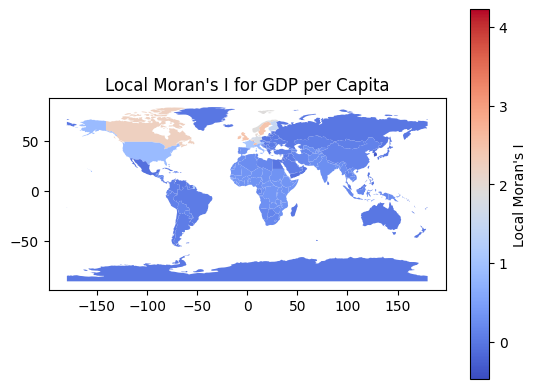

In [23]:
# Perform Local Moran's I
local_moran = Moran_Local(world['gdp_per_capita'], weights)

# Plot Local Moran's I
world['local_moran'] = local_moran.Is
plt.figure(figsize=(10, 6))
world.plot(column='local_moran', legend=True, cmap='coolwarm', legend_kwds={'label': "Local Moran's I"})
plt.title("Local Moran's I for GDP per Capita")
plt.show()

## Multicollinearity check

In [25]:
# Prepare the data for multicollinearity check
X = world[['pop_density', 'area', 'pop_est']]
X = X.dropna()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


       feature       VIF
0  pop_density  1.090301
1         area  1.000008
2      pop_est  1.090309


## Initial Regression Model (OLS)

In [27]:
# Prepare the data for linear regression
X = world[['pop_density', 'area', 'pop_est']]
y = world['gdp_per_capita']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the linear regression model
linear_model = sm.OLS(y, X).fit()

# Display the summary of the linear regression model
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:         gdp_per_capita   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     24.43
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           3.13e-13
Time:                        23:10:04   Log-Likelihood:                -2016.5
No. Observations:                 177   AIC:                             4041.
Df Residuals:                     173   BIC:                             4054.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.609e+04   2000.942      8.039      

## Geographically Weighted Regression (GWR)

In [56]:
# Prepare the data for GWR
coordinates = np.column_stack([world.geometry.centroid.x, world.geometry.centroid.y])
X = np.array(world[['pop_density', 'area', 'pop_est']])
y = np.array(world['gdp_per_capita']).reshape(-1, 1)

# Add a constant term for the intercept
X = np.hstack([np.ones((X.shape[0], 1)), X])

# Bandwidth selection for GWR
gwr_selector = Sel_BW(coordinates, y, X)
gwr_bw = gwr_selector.search()

# Train the GWR model
gwr_model = GWR(coordinates, y, X, gwr_bw)
gwr_results = gwr_model.fit()

# Display GWR summary
print(gwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                                 177
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       81503702404.627
Log-likelihood:                                                   -2016.529
AIC:                                                               4041.059
AICc:                                                              4043.409
BIC:                                                           81503701509.153
R2:                                                                   0.298
Adj. R2:                                                              0.285

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- 

## Multiscale Geographically Weighted Regression (MGWR)

In [47]:
# Bandwidth selection for MGWR
mgwr_selector = Sel_BW(coordinates, y, X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2], multi_bw_max=[len(world)], tol_multi=1e-3)

# Train the MGWR model using the selector, not the bandwidth array directly
mgwr_model = MGWR(coordinates, y, X, selector=mgwr_selector)
mgwr_results = mgwr_model.fit()

# Display MGWR summary
print(mgwr_results.summary())

Inference: 100%|██████████| 1/1 [00:00<00:00, 995.56it/s]

Model type                                                         Gaussian
Number of observations:                                                 177
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       81503702404.627
Log-likelihood:                                                   -2016.529
AIC:                                                               4041.059
AICc:                                                              4043.409
BIC:                                                           81503701509.153
R2:                                                                   0.298
Adj. R2:                                                              0.285

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- 

## Model Comparison and Selection

In [57]:
# Compare Adjusted R-Square
print(f"OLS Adjusted R-Squared: {linear_model.rsquared_adj}")
print(f"GWR Adjusted R-Squared: {gwr_results.R2}")
print(f"MGWR Adjusted R-Squared: {mgwr_results.R2}")


OLS Adjusted R-Squared: 0.28539588781631875
GWR Adjusted R-Squared: 0.6654612035973567
MGWR Adjusted R-Squared: 0.8040719282315886


In [58]:
# Compare AIC
print(f"OLS AIC: {linear_model.aic}")
print(f"GWR AIC: {gwr_results.aic}")
print(f"MGWR AIC: {mgwr_results.aic}")

OLS AIC: 4041.058566434594
GWR AIC: 3965.7740359904583
MGWR AIC: 3890.480803652507


In [61]:
# Prediction and MSE
y_pred_ols = linear_model.predict(X)
y_pred_gwr = gwr_results.predy
y_pred_mgwr = mgwr_results.predy

rmse_ols = np.sqrt(np.mean((y - y_pred_ols)**2))
rmse_gwr = np.sqrt(np.mean((y - y_pred_gwr)**2))
rmse_mgwr = np.sqrt(np.mean((y - y_pred_mgwr)**2))

print(f"OLS RMSE: {rmse_ols}")
print(f"GWR RMSE: {rmse_gwr}")
print(f"MGWR RMSE: {rmse_mgwr}")

OLS RMSE: 29165.476186932792
GWR RMSE: 14809.002534870755
MGWR RMSE: 11333.156724828692


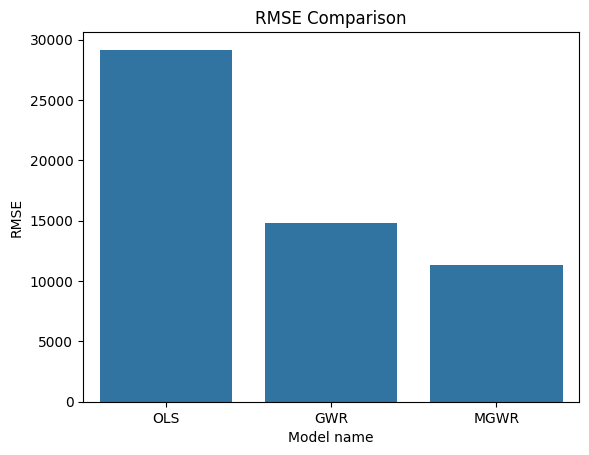

In [65]:
plt.title('RMSE Comparison')
sns.barplot(x = ["OLS", "GWR", "MGWR"], y = [rmse_ols, rmse_gwr, rmse_mgwr])
plt.xlabel("Model name")
plt.ylabel("RMSE")
plt.show()

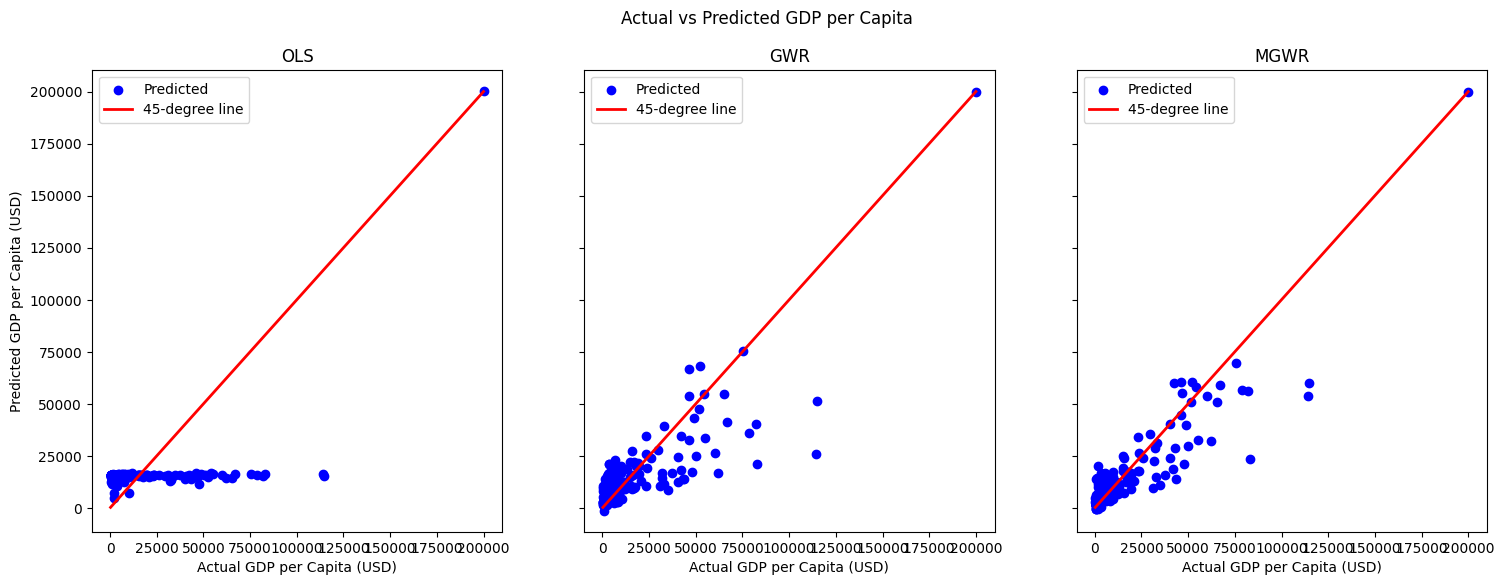

In [67]:
# Subplot for Actual vs Predicted GDP per Capita for OLS, GWR, and MGWR
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# OLS
axes[0].scatter(y, y_pred_ols, color='blue', label='Predicted')
axes[0].plot([min(y), max(y)], [min(y), max(y)], color='red', linewidth=2, label='45-degree line')
axes[0].set_title('OLS')
axes[0].set_xlabel('Actual GDP per Capita (USD)')
axes[0].set_ylabel('Predicted GDP per Capita (USD)')
axes[0].legend()

# GWR
axes[1].scatter(y, y_pred_gwr, color='blue', label='Predicted')
axes[1].plot([min(y), max(y)], [min(y), max(y)], color='red', linewidth=2, label='45-degree line')
axes[1].set_title('GWR')
axes[1].set_xlabel('Actual GDP per Capita (USD)')
axes[1].legend()

# MGWR
axes[2].scatter(y, y_pred_mgwr, color='blue', label='Predicted')
axes[2].plot([min(y), max(y)], [min(y), max(y)], color='red', linewidth=2, label='45-degree line')
axes[2].set_title('MGWR')
axes[2].set_xlabel('Actual GDP per Capita (USD)')
axes[2].legend()

fig.suptitle('Actual vs Predicted GDP per Capita')
plt.show()

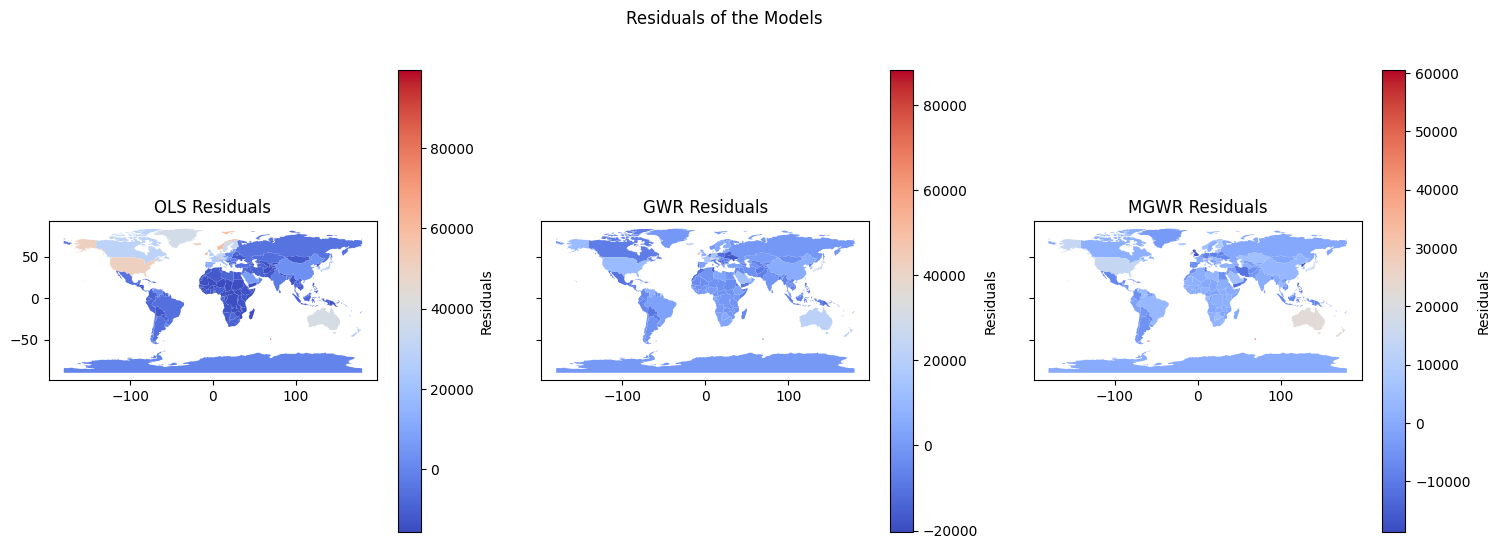

In [73]:
# Residuals for OLS, GWR, and MGWR
residuals_ols = y.flatten() - y_pred_ols
residuals_gwr = y.flatten() - y_pred_gwr.flatten()
residuals_mgwr = y.flatten() - y_pred_mgwr.flatten()

# Add residuals to the GeoDataFrame
world['residuals_ols'] = residuals_ols
world['residuals_gwr'] = residuals_gwr
world['residuals_mgwr'] = residuals_mgwr

# Plot residuals
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# OLS
world.plot(column='residuals_ols', ax=axes[0], legend=True, cmap='coolwarm', legend_kwds={'label': "Residuals"})
axes[0].set_title('OLS Residuals')

# GWR
world.plot(column='residuals_gwr', ax=axes[1], legend=True, cmap='coolwarm', legend_kwds={'label': "Residuals"})
axes[1].set_title('GWR Residuals')

# MGWR
world.plot(column='residuals_mgwr', ax=axes[2], legend=True, cmap='coolwarm', legend_kwds={'label': "Residuals"})
axes[2].set_title('MGWR Residuals')

fig.suptitle('Residuals of the Models')
plt.show()

<Figure size 1000x600 with 0 Axes>

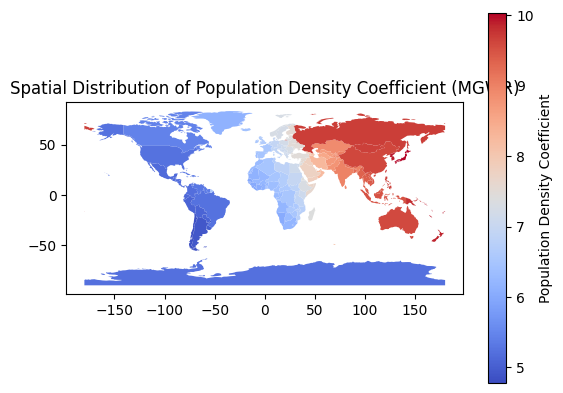

In [69]:
# Plot the spatial distribution of the population density coefficient for MGWR
world['pop_density_coef_mgwr'] = mgwr_results.params[:, 1]

plt.figure(figsize=(10, 6))
world.plot(column='pop_density_coef_mgwr', legend=True, cmap='coolwarm', legend_kwds={'label': "Population Density Coefficient"})
plt.title('Spatial Distribution of Population Density Coefficient (MGWR)')
plt.show()

<Figure size 1000x600 with 0 Axes>

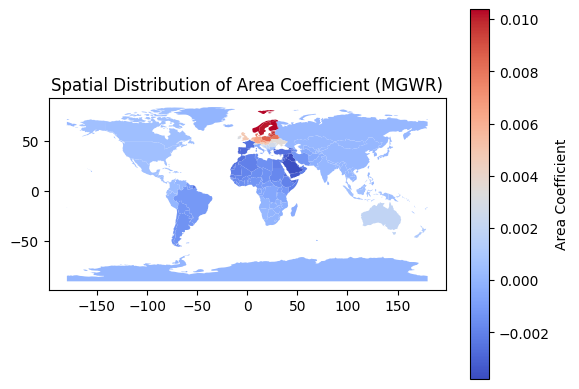

In [70]:
# Plot the spatial distribution of the area coefficient for MGWR
world['area_coef_mgwr'] = mgwr_results.params[:, 2]

plt.figure(figsize=(10, 6))
world.plot(column='area_coef_mgwr', legend=True, cmap='coolwarm', legend_kwds={'label': "Area Coefficient"})
plt.title('Spatial Distribution of Area Coefficient (MGWR)')
plt.show()


<Figure size 1000x600 with 0 Axes>

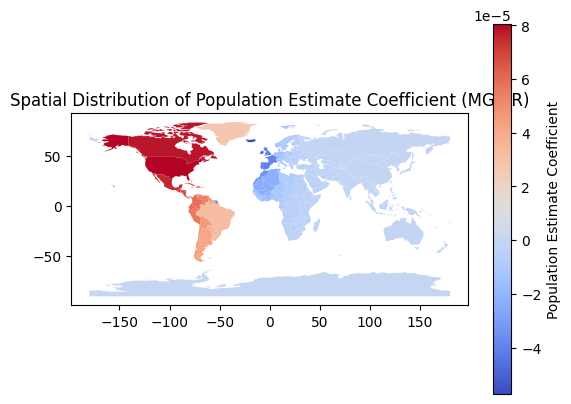

In [71]:
# Plot the spatial distribution of the population estimate coefficient for MGWR
world['pop_est_coef_mgwr'] = mgwr_results.params[:, 3]

plt.figure(figsize=(10, 6))
world.plot(column='pop_est_coef_mgwr', legend=True, cmap='coolwarm', legend_kwds={'label': "Population Estimate Coefficient"})
plt.title('Spatial Distribution of Population Estimate Coefficient (MGWR)')
plt.show()